# Collect results

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [2]:
import torch
import torch.nn as nn
from typing import Optional

def get_layer(model, layer_of_interest_name):
    return dict(model.named_modules())[layer_of_interest_name]

def get_param(model, param_of_interest_name):
    return dict(model.named_parameters())[param_of_interest_name]

def get_activation_and_grad_wrt_param(
    model: nn.Module,
    inputs: torch.Tensor,
    layer_of_interest_name: str,
    param_of_interest: torch.Tensor,
    return_vector=False
):
    # We'll store the activation from the forward hook
    activation: Optional[torch.Tensor] = None
    
    def forward_hook(module, in_t, out_t):
        nonlocal activation
        activation = out_t

    # Find the module by name
    layer_of_interest = get_layer(model, layer_of_interest_name)

    # Register hook
    hook_handle = layer_of_interest.register_forward_hook(forward_hook)

    # Forward pass
    model.zero_grad(set_to_none=True)
    out = model(inputs)  # Could be logits or next layer's hidden states, doesn't matter
    hook_handle.remove()

    # Now `activation` should hold h^l
    if activation is None:
        raise RuntimeError(f"No activation captured from layer {layer_of_interest_name}.")

    # For the simplest approach: we do d( sum(h^l) ) / d param
    # That is effectively a shape match if we pass grad_outputs = ones_like(activation).
    grad_outputs = torch.ones_like(activation[0,0], requires_grad=True)

    # Get derivative of the [0,0] entry (first batch, first nueron).
    grad_tuple = torch.autograd.grad(
        outputs=activation[0,0],    # or out if we want ∂out/∂W, but here we do activation
        inputs=param_of_interest,
        grad_outputs=grad_outputs,
        retain_graph=False,  # if we want to do more grads afterwards
        create_graph=False,  # if we don't need higher order derivatives
        allow_unused=True
    )
    grad = grad_tuple[0]

    # Return both the captured h^l and the gradient
    return activation[0,0] if not return_vector else activation[0,:], grad


def get_first_order_taylor(delta_w, grad):
    return torch.sum(delta_w[0,:] * grad[0:])


In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# A minimal test model
class SimpleLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim, bias=False)

    def forward(self, x):
        phi_x = torch.relu(x)  # This is your φ(x)
        return self.linear(phi_x)

def test_derivative_wrt_first_row():
    torch.manual_seed(0)
    in_dim = 4
    out_dim = 3
    model = SimpleLayer(in_dim=in_dim, out_dim=out_dim)

    # Input x
    x = torch.randn(1, in_dim, requires_grad=True)

    # Get param and grad
    W = get_param(model, "linear.weight")
    phi_x = torch.relu(x)
    act, grad = get_activation_and_grad_wrt_param(
        model=model,
        inputs=x,
        layer_of_interest_name="linear",
        param_of_interest=W
    )

    # The derivative of (W φ(x))_0 w.r.t. W is a matrix whose first row is φ(x), others are 0
    expected_grad = torch.zeros_like(W)
    expected_grad[0, :] = phi_x

    assert torch.allclose(grad, expected_grad, atol=1e-6), f"Gradient mismatch:\nGot: {grad}\nExpected: {expected_grad}"

    print("Test passed!")

# Run the test
test_derivative_wrt_first_row()

Test passed!


In [4]:
import math 

# Define a residual branch
class ResidualBranch(nn.Module):
    def __init__(self, N, K):
        super().__init__()
        self.layers = nn.ModuleList()
        self.activs = nn.ModuleList()
        self.N = N
        for _ in range(K):
            self.activs.append(nn.ReLU())
            self.layers.append(nn.Linear(N,N,bias=False))
        self.reset_parameters()

    def forward(self, x):
        for layer, activ in zip(self.layers, self.activs):
            x = activ(x)
            x = math.sqrt(2/self.N) * layer(x)
        return x
    

    def reset_parameters(self) -> None:
        for layer in self.layers:   
            with torch.no_grad():
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
                layer.weight.normal_(0, 1)
            
# Toy residual model   
class ToyModel(nn.Module):
    def __init__(self, D, N_out, N, L, K, alpha, base_depth):
        super(ToyModel, self).__init__()
        
        self.D = D
        self.L = L
        self.N = N
        self.alpha = alpha
        self.base_depth = base_depth
        
        self.activations = []
        
        self.readin = nn.Linear(D, N, bias=False)
        
        self.branches = nn.ModuleList()
        
        for _ in range(L):
            branch = ResidualBranch(N, K)
            self.branches.append(branch)
            
        self.readout = nn.Linear(N,N_out,bias=False)
    
    def forward(self, x):
        self.activations = []
        x = 1/math.sqrt(self.D ) * self.readin(x)
        
        for branch in self.branches:
            x = x + 1/((self.L/self.base_depth)**self.alpha) * branch(x)
            self.activations.append(x)
        
        x = 1/(self.N) * self.readout(x)
        
        return x
    
    def reset_parameters(self) -> None:
        for layer in [self.readin, self.readout]:
            with torch.no_grad():
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
                layer.weight.normal_(0,1)

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

seed = 101
torch.manual_seed(seed)
np.random.seed(seed)

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL to Tensor
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalize to mean and std of MNIST
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to shape: [784]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [6]:
train_iter = iter(train_loader)
x, y = next(train_iter)

K = 2
D = 784
N_out = 10
N = 256
optim = 'adam'
lr = 0.04 if optim == 'sgd' else 0.0001
max_steps = 1
Ls = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
base_depth = Ls[0]
seeds = 50


weight_of_interest_name = 'branches.1.layers.0.weight'
layer_of_interest_name = 'branches.1'
activation_of_interest = 'branches.1.activs.0' # This is usd just for some testing

In [7]:
from tqdm import tqdm
import numpy as np


def experiment(alpha):
    delta_hs = np.zeros((seeds, len(Ls)))
    param_diff = np.zeros((seeds, len(Ls)))
    losses = np.zeros((len(Ls), max_steps))

    for s in tqdm(range(seeds)):
        for i,L in enumerate(Ls):
            train_iter = iter(train_loader) # re-set the loader
            
            model = ToyModel(D, N_out, N, L, K, alpha, base_depth)

            param_0 = get_param(model, weight_of_interest_name)
            activ_0, grad_0 = get_activation_and_grad_wrt_param(model, x, layer_of_interest_name, param_0)
            param_0 = param_0.clone()
        
            
            if optim == "sgd":
                lr_depth_scale = (L/base_depth)**(2*alpha - 1) if alpha != 0 else 1
                optimizer = torch.optim.SGD(model.parameters(), lr=lr * lr_depth_scale * N)
            elif optim == "adam":
                lr_depth_scale = (L/base_depth)**(alpha - 1) if alpha != 0 else 1
                eps_depth_scale = (L/base_depth)**(-alpha)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr * 1/math.sqrt(N) * lr_depth_scale, eps=1e-8 * eps_depth_scale)
            criterion = nn.CrossEntropyLoss()
            
            #Only make the network trainable with respect to the weights of interest
            for name, param in model.named_parameters():
                if weight_of_interest_name != name:
                    param.requires_grad = False
                    
            step = 0
            for xt, yt in train_iter:
                optimizer.zero_grad()
                model.train()
                y_hat = model(xt)
                
                loss = criterion(y_hat, yt)

                loss.backward()
                optimizer.step()
                
                losses[i, step] = loss.item()
                
                step += 1
                if step >= max_steps:
                    break
            
            # make the network trainable with respect to all the weights (note: this does not affect the activations because we are not training from here anyway). 
            # This is done only to differentiate "activation_of_interest" with respect to the weights in the case K=1. 
            for name, param in model.named_parameters():
                param.requires_grad = True
            
            param_1 = get_param(model, weight_of_interest_name)
            activ_1, grad_1 = get_activation_and_grad_wrt_param(model, x, layer_of_interest_name, param_1)
        
            if K == 1:
                activ_11, _ = get_activation_and_grad_wrt_param(model, x, activation_of_interest, param_1, return_vector=True)
                assert torch.allclose(grad_1[0,:], math.sqrt(2/N) * activ_11[0,:], atol=1e-8), f"Gradient mismatch"
            
            ft = get_first_order_taylor((param_1-param_0), grad_0) 
            
            param_diff[s,i] = torch.norm(param_1 - param_0).detach().item()
            
            # activ_1 -> branch(t=1)
            # activ_0 -> branch(t=0) (zero-th order term)
            # ft -> (theta_1 - theta_0)^T \nabla branch |_{theta=\theta0} (first order term)
            
            ft_lin = activ_0 + ft
            delta_h = torch.abs((activ_1 - ft_lin)/ft_lin)
            delta_hs[s, i] = delta_h.detach().item()
        
    return delta_hs, param_diff, losses

In [8]:
delta_hs_1, param_diff_1 ,_ = experiment(alpha=1.0)
delta_hs_05, param_diff_05, _ = experiment(alpha=0.5)
delta_hs_0, param_diff_0, _ = experiment(alpha=0.0)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [19:46<00:00, 23.72s/it]


In [10]:
np.save('delta_hs_1.npy', delta_hs_1)
np.save('param_diff_1.npy', param_diff_1)
np.save('delta_hs_05.npy', delta_hs_05)
np.save('param_diff_05.npy', param_diff_05)
np.save('delta_hs_0.npy', delta_hs_0)
np.save('param_diff_0.npy', param_diff_0)

# Plotting

In [26]:
param_diff_05.shape

(50, 12)

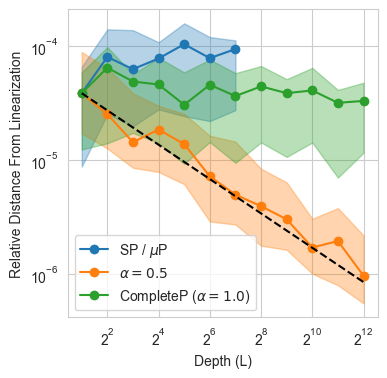

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

delta_hs_1 = np.load('delta_hs_1.npy') # (n_seeds, n_depths_tested)
delta_hs_05 = np.load('delta_hs_05.npy') # (n_seeds, n_depths_tested)
delta_hs_0 = np.load('delta_hs_0.npy') # (n_seeds, n_depths_tested)

param_diff_1 = np.load('param_diff_1.npy') # (n_seeds, n_depths_tested)
param_diff_05 = np.load('param_diff_05.npy') # (n_seeds, n_depths_tested)
param_diff_0 = np.load('param_diff_0.npy') # (n_seeds, n_depths_tested)

x = np.array(Ls, dtype=np.float32)
y_alpha05 = np.median(delta_hs_05, axis=0)
y_alpha05_first_quartile = np.quantile(delta_hs_05, q=0.25, axis=0)
y_alpha05_third_quartile = np.quantile(delta_hs_05, q=0.75, axis=0)

y_alpha1 = np.median(delta_hs_1, axis=0)
y_alpha1_first_quartile = np.quantile(delta_hs_1, q=0.25, axis=0)
y_alpha1_third_quartile = np.quantile(delta_hs_1, q=0.75, axis=0)

y_sp_and_mup = np.median(delta_hs_0, axis=0)
y_sp_and_mup_first_quartile = np.quantile(delta_hs_0, q=0.25, axis=0)
y_sp_and_mup_third_quartile = np.quantile(delta_hs_0, q=0.75, axis=0)

y_alpha1 = (y_alpha05[0] / y_alpha1[0]) * y_alpha1
y_alpha1_first_quartile = (y_alpha05[0] / y_alpha1[0]) * y_alpha1_first_quartile
y_alpha1_third_quartile = (y_alpha05[0] / y_alpha1[0]) * y_alpha1_third_quartile

y_sp_and_mup = (y_alpha05[0] / y_sp_and_mup[0]) * y_sp_and_mup
y_sp_and_mup_first_quartile = (y_alpha05[0] / y_sp_and_mup[0]) * y_sp_and_mup_first_quartile
y_sp_and_mup_third_quartile = (y_alpha05[0] / y_sp_and_mup[0]) * y_sp_and_mup_third_quartile

y_trend = (y_alpha05[0] * np.sqrt(x[0])) / np.sqrt(x)

plt.figure(figsize=(4, 4))
plt.plot(x, y_sp_and_mup, marker='o', label=r'SP / $\mu$P', color='tab:blue')
plt.fill_between(x=x, y1=y_sp_and_mup_first_quartile, y2=y_sp_and_mup_third_quartile, color='tab:blue', alpha=0.33)
plt.plot(x, y_alpha05, marker='o', label=r'$\alpha=0.5$', color='tab:orange')
plt.fill_between(x=x, y1=y_alpha05_first_quartile, y2=y_alpha05_third_quartile, color='tab:orange', alpha=0.33)
plt.plot(x, y_alpha1, marker='o', label=r'CompleteP ($\alpha=1.0$)', color='tab:green')
plt.fill_between(x=x, y1=y_alpha1_first_quartile, y2=y_alpha1_third_quartile, color='tab:green', alpha=0.33)
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel('Depth (L)')
# plt.title(optim)
plt.ylabel('Relative Distance From Linearization')
# plt.plot(Ls, y_trend, linestyle='--', label=r'$y=\frac{1}{\sqrt{L}}$', color='black')
plt.plot(Ls, y_trend, linestyle='--', color='black')
plt.legend()
# plt.savefig('linearization_distance.pdf')
plt.show()

In [43]:
x.shape

(12,)

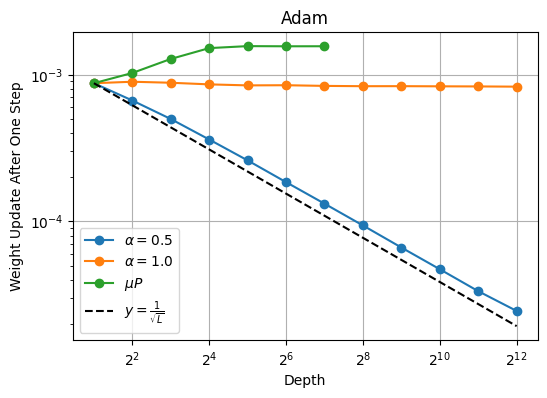

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

title = "Adam" if optim == "adam" else "SGD"

x = np.array(Ls, dtype=np.float32)
y = param_diff_05.mean(axis=0)
y1 = param_diff_1.mean(axis=0)
y0 = param_diff_0.mean(axis=0)

y1 = y[0] / y1[0] * y1
y0 = y[0] / y0[0] * y0

y_trend = y[0] * np.sqrt(x[0]) / np.sqrt(x)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(x, y, marker='o', label=r'$\alpha=0.5$')
plt.plot(x, y1, marker='o', label=r'$\alpha=1.0$')
plt.plot(x, y0, marker='o', label=r'$\mu P$')
plt.xscale('log', base=2)
plt.yscale('log')  
plt.xlabel('Depth')
plt.title(title)
plt.ylabel('Weight Update After One Step')
plt.plot(Ls, y_trend, linestyle='--', label=r'$y=\frac{1}{\sqrt{L}}$', color='black')
plt.legend()
plt.grid(True)
plt.show()